## Тестирование гипотез для увеличения выручки

Есть  список гипотез для увеличения выручки крупного интернет- магазина.
Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

Данные для первой части

- Файл /datasets/hypothesis.csv. 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Данные для второй части
- Файл /datasets/orders.csv. 
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.
- Файл /datasets/visitors.csv.
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### 1 Часть. Приоритизация гипотез.

In [63]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from collections import Counter
from scipy import stats as st
import datetime as dt

In [64]:
#Сформируем датасеты

hypothesis = pd.read_csv('C://Users//Марина/Downloads//hypothesis.csv')
orders = pd.read_csv('C://Users//Марина/Downloads//orders.csv')
visitors = pd.read_csv('C://Users//Марина/Downloads//visitors.csv')


In [65]:
data = [hypothesis, orders, visitors] # посмотрим таблицы, сделаем предобработку данных


In [66]:
data

[                                                                                                     Hypothesis  \
 0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
 1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
 2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
 3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
 4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   
 5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
 6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
 7              Добавить форму подписки на все основные страницы, чтобы 

In [67]:
# расммотрим информацию подробнее
for tab in data:
    display(tab.describe())
    display(tab.info())
    display(tab.duplicated().sum())

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

0

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

0

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

0

In [68]:
 # Изменим в таблице orders и visitors  фармат в поле дата.
orders['date'] = pd.to_datetime(
    orders['date'], format='%Y-%m-%d')   
    
    
visitors['date'] = pd.to_datetime(
    visitors['date'], format='%Y-%m-%d')

In [69]:
#приведем к нижнему регистру названия столбцов в таблице hypothesis
hypothesis.columns = map(str.lower, hypothesis.columns)

Дубликатов и пропусков в данных нет, поменяли формат даты, изменили названия столбцов.

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [70]:
#Посчитаем ICE влияние на пользователей умножим на  уверенность в гипотезе и разделим на затраты

hypothesis['ICE'] = ( hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
pd.options.display.max_colwidth=400
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


#### Добавим в формулу охват пользователей и Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [71]:
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


#### Приоритизация гипотез при применении RICE вместо ICE изменилась. 

Пр применении  ICE на первом месте гипотеза под номером 8 , при  RICE выше показатель у гипотезы 7
Это произошло из за того, что показатель  охвата пользователей (reach) у 7 гипотезы выше всех - максимальный 10 балов, у 8й гипотезы всего 1 бал.
Нужно учитывать сколько пользователей затронет гипотеза.
Гипотеза номер 7 в приоритете.


### Часть. Анализ A/B-теста

In [73]:
#Проверим, есть ли пользователи, которые попали в обе группы
duplicat = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
duplicat

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830], dtype=int64)

In [74]:
#Удалим пользователей, которые попали в обе группы
orders = orders[~orders['visitorId'].isin(duplicat)]

#### Построем график кумулятивной выручки по группам

Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов

In [75]:
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


Объявим переменную ordersAggregated, содержащую:
* дату;
* группу A/B-теста;
* число уникальных заказов в группе теста по указанную дату включительно;
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
* суммарную выручку заказов в группе теста по указанную дату включительно.

In [76]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 
      'group' : 'max', 
      'transactionId' : 'nunique',
      'visitorId' : 'nunique', 
      'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


Объявим переменную visitorsAggregated, содержащую:
* дату;
* группу A/B-теста;
* количество уникальных посетителей в группе теста по указанную дату включительно.

In [77]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max',
                                                                                                                                               'group' : 'max', 
                                                                                                                                               'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Определим переменную cumulativeData, объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group'

In [78]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [79]:
#Переименуем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# посмотрим получившуюся таблицу
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.

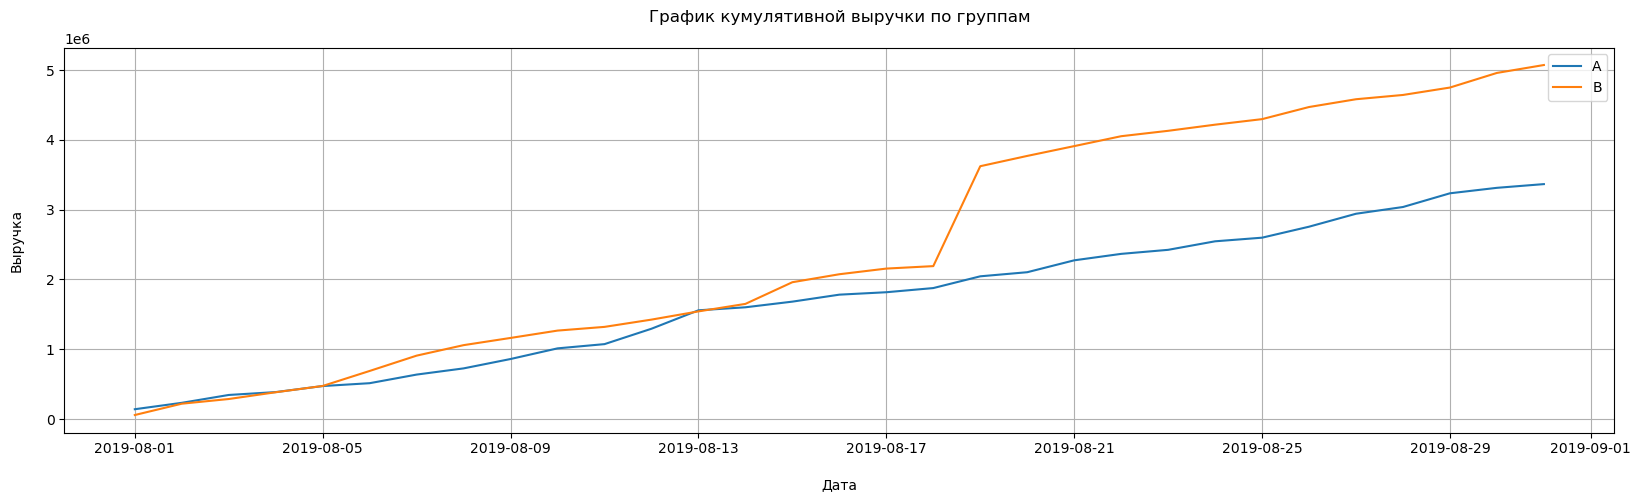

In [80]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Выручка\n')
plt.grid()
plt.legend() 
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако в группе В наблюдается резкий скачек( 2019.08.18). Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы нужно проанализировать.


#### Построем график кумулятивного среднего чека по группам. 

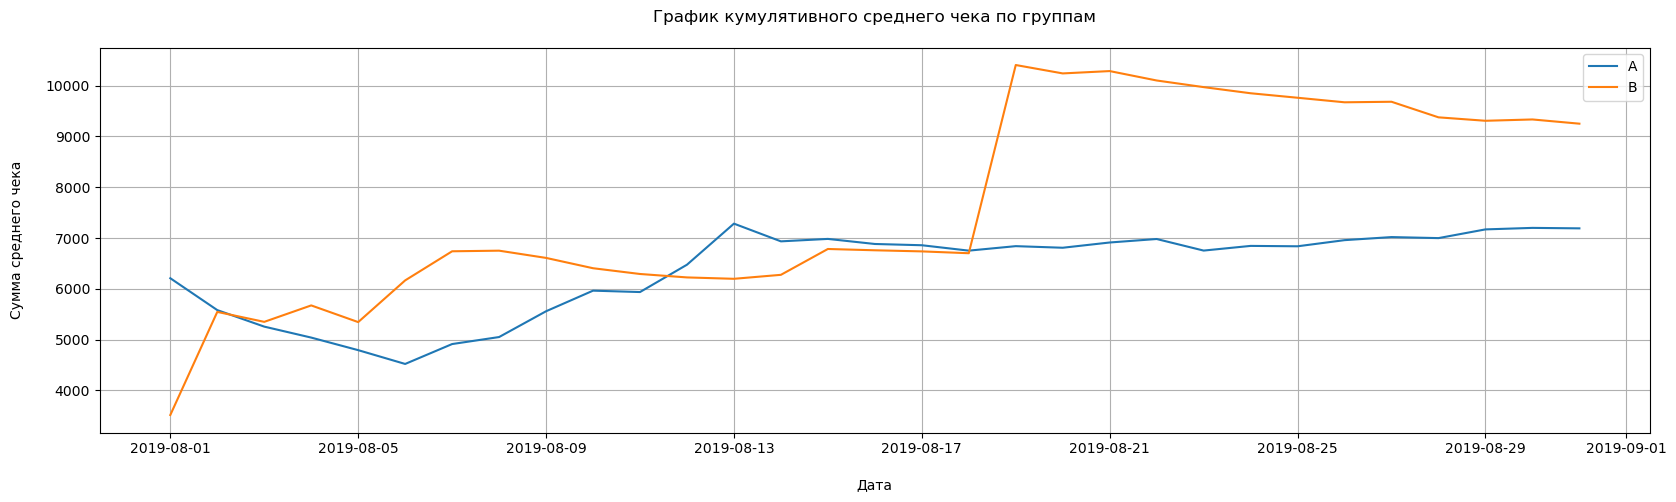

In [81]:
# разделим кумулятивную выручку на кумулятивное число заказов
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Сумма среднего чека\n')
plt.legend()
plt.show()

График показывает не равномерность среднего чека, есть резкие всплески для группы В

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

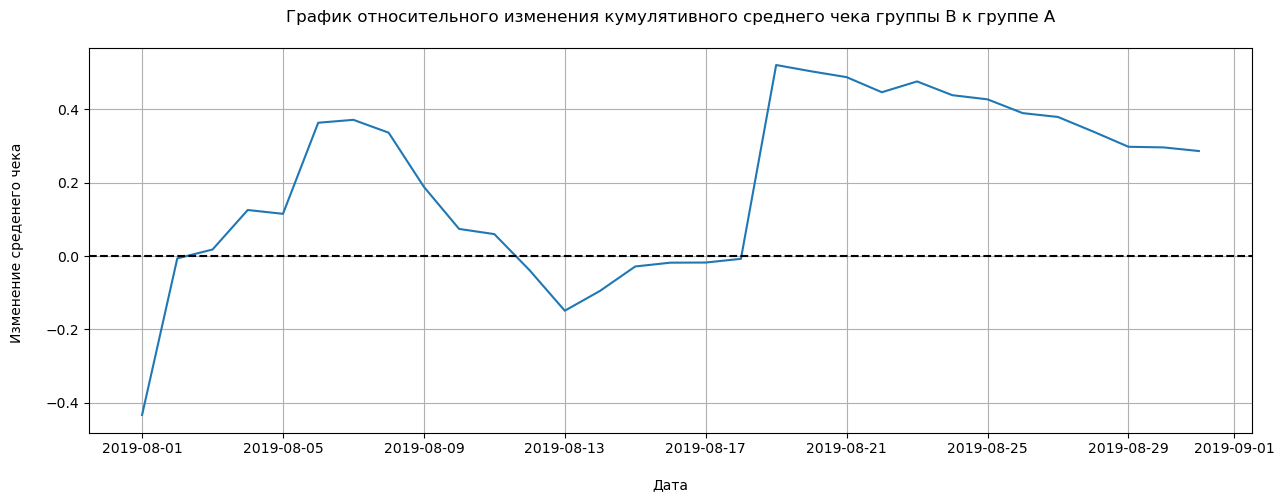

In [82]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Изменение среденего чека \n')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы!

#### Построем график кумулятивного среднего количества заказов на посетителя по группам.

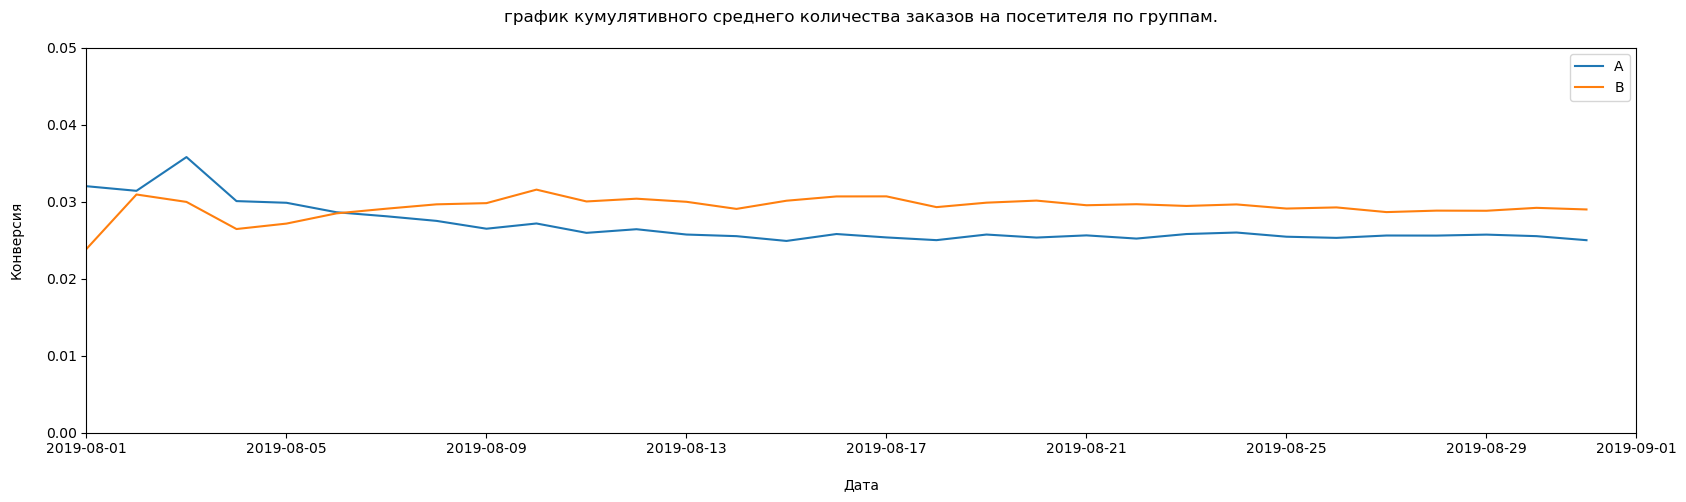

In [83]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(20,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('график кумулятивного среднего количества заказов на посетителя по группам.\n  ')
plt.xlabel('\nДата')
plt.ylabel('Конверсия\n')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.show()

В начале конверсия группы А была выше, но вскоре группа В вышла вперед

#### Построем график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

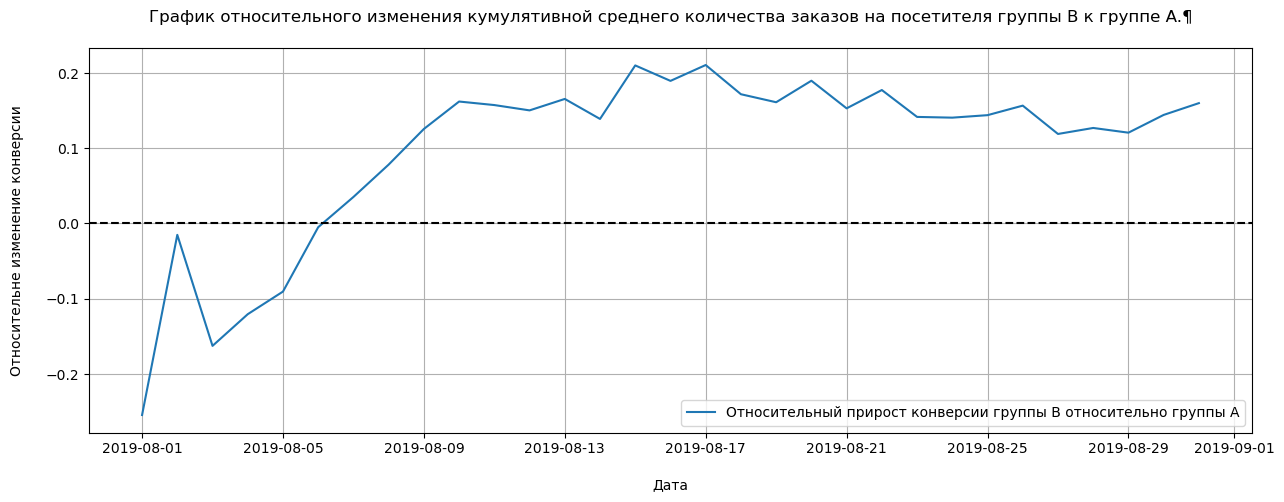

In [84]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивной среднего количества заказов на посетителя группы B к группе A.¶\n  ')
plt.xlabel('\nДата')
plt.ylabel('Относительне изменение конверсии\n')
plt.show()

На графике видно резкий скачок кумулятивной среднего количества заказов на посетителя группы B к группе A

#### Построем точечный график количества заказов по пользователям.

In [85]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


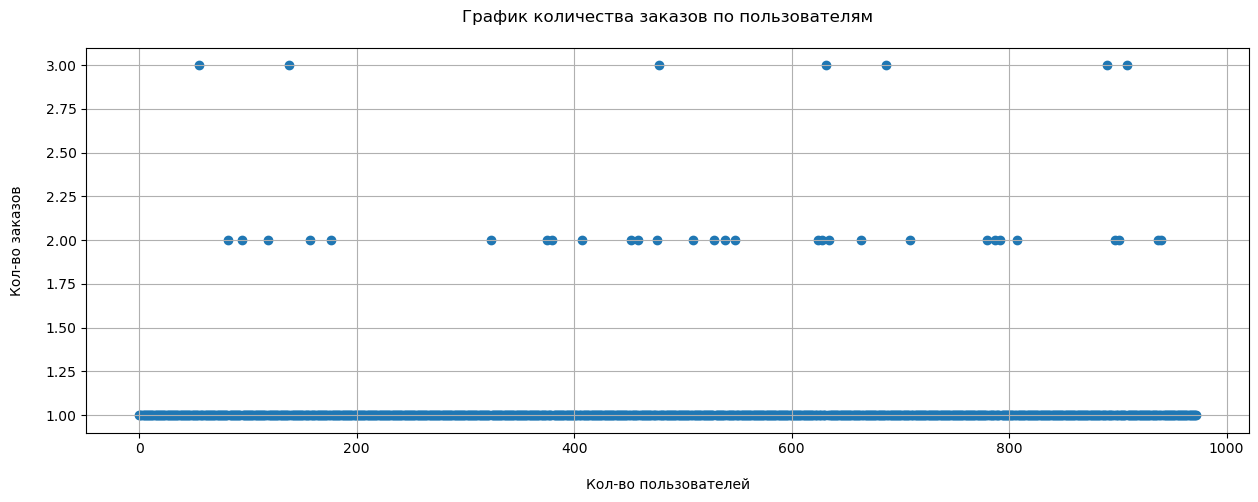

In [86]:
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям\n  ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Кол-во заказов\n')

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

Покупателей совершивщих более 3 заказов очень мало, возможно это выбросы. 

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [87]:
np.percentile(ordersByUsers['orders'], [ 95, 99])

array([1., 2.])

95% покупателей совершают не более 1й покупки, 99% совершают не более 2х. Все что больше 2 покупок можно не брать в расчет

#### Построем точечный график стоимостей заказов.

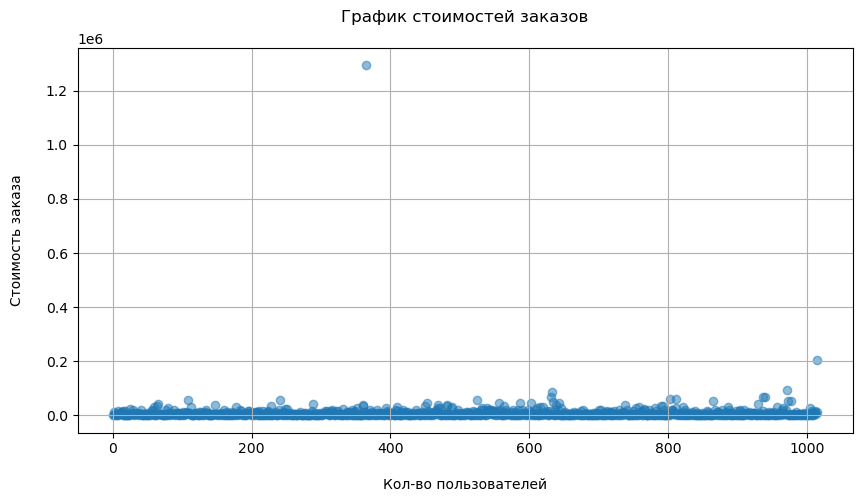

In [88]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.grid()
plt.title('График стоимостей заказов\n ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.show()

На графике видно явные выбросы искажающие данные, уберем их.

In [89]:
#уберем заказы стоимостью выше 200000
now_orders = orders[orders['revenue']<=200000]['revenue']
now_orders.sort_values()

459        50
584        50
756        50
933        60
404        70
        ...  
1099    65710
1103    66350
743     67990
744     86620
1136    92550
Name: revenue, Length: 1014, dtype: int64

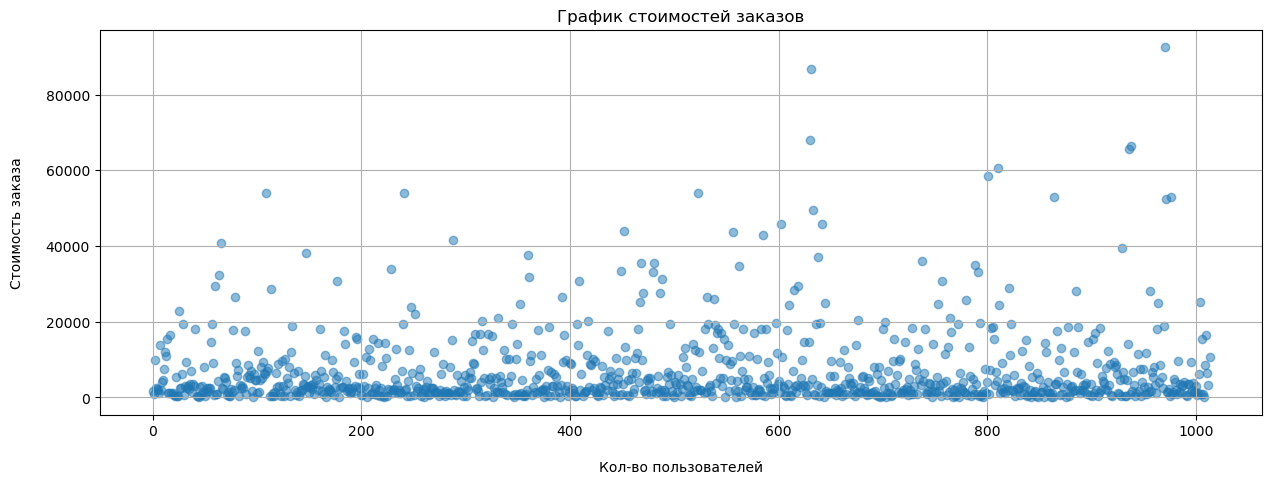

In [90]:
xn_values = pd.Series(range(0,len(now_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(xn_values, now_orders, alpha=0.5)
plt.show()

Стоимость большинства заказов ниже 40000

#### Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [91]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

 у 95% заказов стоимость не выше 26785 , у 99% заказов не выше 53904 Все что выше будем считать аномальными

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем гипотезы.
- Нулевая  H0: различий в среднем количестве заказов на посетителя между руппами A и B по «сырым» данным нет. 
- Альтернативная  H1: различия  в среднем количестве заказов на посетителя между руппами A и B по «сырым» данным  есть.

Соберем в общую таблицу все данные по заказам и визитам, добавив кумулятивные показатели

In [92]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [93]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [94]:
tabl = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
tabl.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [95]:
#создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'], где для пользователей, 
#совершивших хотя бы 1 заказ, будет указано число заказов. 

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 
# Объявите переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. 
# А пользователям без заказов — нули.

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(tabl['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(tabl['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)




In [96]:
display('p-value= '"{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

display("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)) 

'p-value= 0.011'

'0.160'

 По «сырым» данным различия в среднем числе заказов групп A и B есть. 
Число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет, отвергаем.

статистически значимые различия в среднем количестве заказов на посетителя между группами есть!

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы.

- Нулевая H0: различий в среднем чеке заказа между группами по «сырым» данным нет.
- Альтернативная H1: различия в среднем чеке заказа между группами по «сырым» данным есть.

In [97]:
display('p-value= ''{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
display('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

'p-value= 0.829'

'0.287'

По «сырым» данным различий в среднем числе заказов групп A и B нет. 
число — p-value = 0.729 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказов между группами нет, не отвергаем. но при этом средний чек группы B значительно выше среднего чека группы A 28,7%  наблюдаемое различие в 28,7% не является стат. значимым.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

 Уберем аномальные значения из данных.
Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 58233 рублей.

In [98]:
# Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 53904 — usersWithExpensiveOrders. 
# Объединим их в таблице abnormalUsers. 
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


In [99]:
# Узнаем, сколько всего аномальных пользователей 
abnormalUsers.shape[0]
abnormalUsers.head(5)

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

Всего 14 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 

In [100]:
# Сначала подготовим выборки количества заказов по пользователям по группам теста:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                tabl['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                tabl['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [101]:
# Применим статистический критерий Манна-Уитни к полученным выборкам:
display('p-value= ''{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

'p-value= 0.007'

'0.189'

 Результаты по среднему количеству заказов немного изменились. Относительный выигрыш группы "B" над "A" равен почти 19% (выше, чем с «сырыми» данными )

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [102]:
display('p-value= '
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

display(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

'p-value= 0.788'

'-0.032'

Средний чек группы В ниже среднего чека группы A на (-3%) в то врмя как по "сырым" данным он был выше  на 28%.
Разница в 3% не является статистически значимой.

P-value увеличился, зачительно  больше 0,05.
Общие выводы по результатам теста не изменились, статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным, нет.
 


#### Примим решение по результатам теста

Мы выяснили, что стат.значимой разницы между группами А и В по среднему чеку нет, следовательно при выросшем количестве заказов с сохранившимся средним чеком выручка будет расти! 
А статистическая значимость между группами А и В по количеству заказов есть и по сырым и по очищенным дынным.

### Вывод:
Основываясь на результатах проведенного А/В теста, рекомендую остановить тест и зафиксировать победу группы В 
У группы В  среднее количесто заказов на посетителя по «очищенным» данным выше чем у группы А на 18,9%